# New York City Green Taxi Data Analysis

Analysis on the data collected by the New York City Taxi on Green Taxis. Green Taxis are the taxis that are not allowed to pick up passengers inside the densely populated areas of Manhattan. I will use the data from September 2015. 

I will be validating various hypotheses, examining patterns and also building a predictve model. I have mentioned the goal of each section at the outset of the sections.

## Imports

In [150]:
#Importing libraries.

import datetime as dt
import os
import pickle
import urllib
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from scipy import stats as st
from scipy.stats import lognorm
from geopy import distance as dist 
from sklearn import linear_model as lm
from sklearn import metrics as mt
from sklearn import svm
from sklearn.ensemble import (GradientBoostingClassifier,
                              RandomForestClassifier, RandomForestRegressor)
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate as cv
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import validation_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings("ignore")
%matplotlib inline

## Question 1: 
> Part A: Programmatically download and load into your favorite analytical tool the trip data for September 2015.

In [2]:
# Downloading data from the website if it's not present in the local directory already.

if not os.path.exists("green_tripdata_2015-09.csv"):
    dataset_url = (
        "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
    )
    urllib.request.urlretrieve(dataset_url, "green_tripdata_2015-09.csv")

In [3]:
#Loading the downloaded dataset into a DataFrame.
tripdata = pd.read_csv("green_tripdata_2015-09.csv")

In [4]:
#Verifying that we have the right data.
tripdata.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979485,40.684956,-73.979431,40.685020,1,...,7.8,0.0,0.0,1.95,0.0,NaN,0.0,9.75,1,2.0
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010796,40.912216,-74.010780,40.912212,1,...,45.0,0.0,0.0,0.00,0.0,NaN,0.0,45.00,1,2.0
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,...,4.0,0.5,0.5,0.50,0.0,NaN,0.3,5.80,1,1.0
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0


In [5]:
tripdata.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type '],
      dtype='object')

In [6]:
# Printing the number of rows and columns using DataFrame attribute: shape.
print("Number of rows:", tripdata.shape[0])
print("Number of Columns:", tripdata.shape[1])

Number of rows: 1494926
Number of Columns: 21


We have 1,494,926 rows and 21 columns in the dataset.

## Question 2:

>Part A: Plot a histogram of the number of the trip distance (“Trip Distance”).

In [7]:
tripdata['Trip_distance'].describe()

count    1.494926e+06
mean     2.968141e+00
std      3.076621e+00
min      0.000000e+00
25%      1.100000e+00
50%      1.980000e+00
75%      3.740000e+00
max      6.031000e+02
Name: Trip_distance, dtype: float64

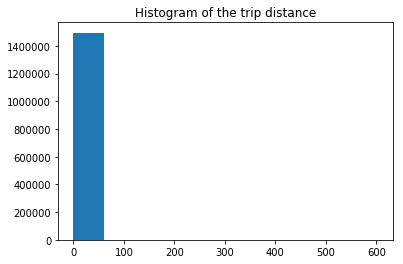

In [8]:
# Plotting histogram of trip distance.
plt.hist(tripdata["Trip_distance"])
plt.title('Histogram of the trip distance')
plt.show()

Clearly, we need to remove outliers to better visualize Trip distance. Let's investigate the outliers through a box plot.

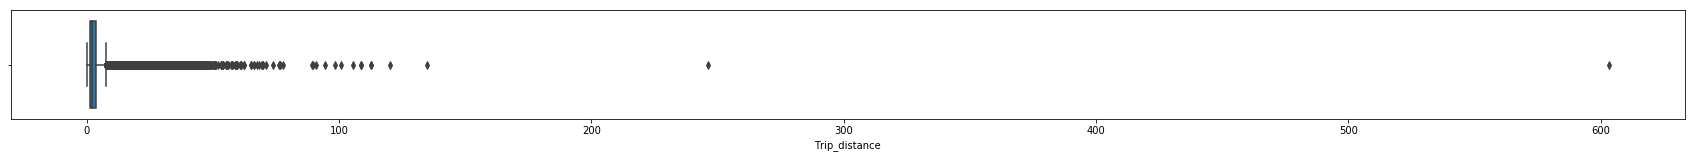

In [9]:
plt.figure(figsize=[30,2])
sns.boxplot(tripdata['Trip_distance'])

In [10]:
print(f"There are {tripdata[tripdata['Trip_distance']==0].shape[0]} records with Trip distance being zero.")

There are 20592 records with Trip distance being zero.


Let's remove records where Trip distance is more than 4 standard deviations away from the mean. Four standard deviations account for 99.9% of the sample population, assuming that Trip distance is normally distributed. Morever, there are many records with Trip distance being 0. This probably have happened because of rounding off. Let's remove them as well.

In [11]:
#Removing records in which trip distance is 0.
Trip_Distance = tripdata.Trip_distance[tripdata.Trip_distance>0]

#Removing records in which trip distance is 3 standard deviations away from mean.
Trip_Distance = Trip_Distance[(Trip_Distance-Trip_Distance.median()).abs() < 4*Trip_Distance.std()]

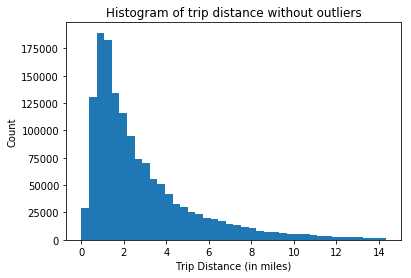

In [12]:
#Plotting histogram with 40 bins.
plt.hist(Trip_Distance,bins = 40)
plt.title('Histogram of trip distance without outliers')
plt.xlabel('Trip Distance (in miles)')
plt.ylabel('Count')
plt.show()

It's evident from the above histogram that trip distance is distributed asymmetrically. In fact, it's skewed towards the right. It appears as though Trip distance follows log-normal distribution. In other words, logarithm of the trip distance follows normal distribution.

Let's try to examine our hypothesis by plotting the log of Trip distance.

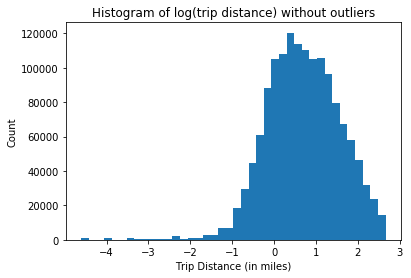

In [13]:
#Plotting histogram with 40 bins.
plt.hist(np.log(Trip_Distance),bins = 40)
plt.title('Histogram of log(trip distance) without outliers')
plt.xlabel('Trip Distance (in miles)')
plt.ylabel('Count')
plt.show()

Let's plot a Q-Q plot (Quartile to Quartile Plot) to check whether Trip data is normally distributed.

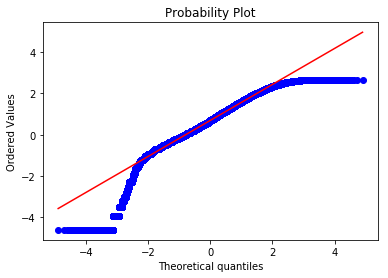

In [14]:
st.probplot(np.log(Trip_Distance), dist="norm", plot=pylab)
pylab.show()

Since the QQ plot of log of the trip data is reasonably a straight line, we can assert that trip data follows lognormal distribution.

###### Interpretation:
Just to reiterate what I have already illustrated in the previous section, I hypothesise that Trip distance follows lognormal distribution (i.e right skewed). This is expected because trip distance is non-negative and starts from 0. Frequency of the trips decrease as trip distance increases. In fact, majority of the trips are of distance within 15 miles.  This is expected since most of the trips are intra-city and therefore short in distance. One more observation is that mean (2.97 miles) is larger median (1.98 miles). This is due to the presense of outliers (long distance trip).

## Question 3

>Part A: Report mean and median trip distance grouped by hour of day.

In [15]:
# Before performing aggregation, we need to extract date and hour from the datetime format.

# Extracting pickup date and dropoff date.
tripdata["Pickup_Date"] = tripdata.lpep_pickup_datetime.apply(
    lambda d: dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S")
)
tripdata["Dropoff_Date"] = tripdata.Lpep_dropoff_datetime.apply(
    lambda d: dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S")
)

# Creating a a new column for Pickup hour using the column created above.
tripdata["Pickup_Hour"] = tripdata.Pickup_Date.apply(lambda h: h.hour)

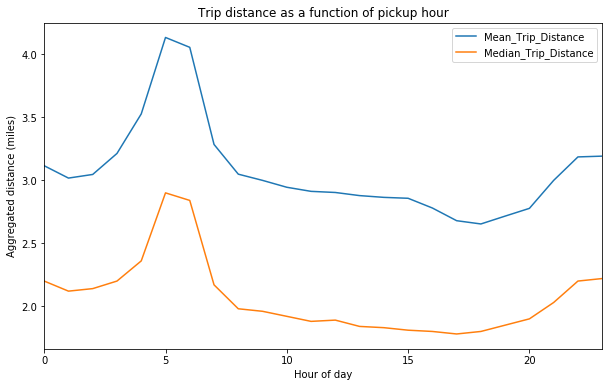

Trip distance grouped by hour of the day: 

 Hour_of_day  Mean_Trip_Distance  Median_Trip_Distance
           0            3.115276                  2.20
           1            3.017347                  2.12
           2            3.046176                  2.14
           3            3.212945                  2.20
           4            3.526555                  2.36
           5            4.133474                  2.90
           6            4.055149                  2.84
           7            3.284394                  2.17
           8            3.048450                  1.98
           9            2.999105                  1.96
          10            2.944482                  1.92
          11            2.912015                  1.88
          12            2.903065                  1.89
          13            2.878294                  1.84
          14            2.864304                  1.83
          15            2.857040                  1.81
          16         

In [16]:
# Pivot table method of dataframe to get aggregation of Trip distance by hour.
Aggregation_Chart = tripdata.pivot_table(
    index="Pickup_Hour", values="Trip_distance", aggfunc=("mean", "median")
).reset_index()

figure, axes = plt.subplots(figsize=(10, 6))
Aggregation_Chart.columns = [
    "Hour_of_day",
    "Mean_Trip_Distance",
    "Median_Trip_Distance",
]

Aggregation_Chart[["Mean_Trip_Distance", "Median_Trip_Distance"]].plot(ax=axes)
plt.ylabel("Aggregated distance (miles)")
plt.xlabel("Hour of day")
plt.title("Trip distance as a function of pickup hour")
plt.xlim([0, 23])
plt.show()
print("Trip distance grouped by hour of the day: \n")

print(Aggregation_Chart.to_string(index=False))


###### Interpretation: 

The graph above shows the trip distance over different hours in the day. Clearly, the trip distance starts increasing at 3AM and peaks at 5AM. After that, it starts decreasing and reaches the nadir at around 5PM. After 5PM, it gradually starts increasing till midnight.

We could observe long distance trips in both morning and late night though morning crest is significantly higher than that of late-night. We can posit that people commuting to work causes this crests in morning and late-night. The possible reason for morning crest being higher than the late-night crest is that people are more likely to call taxis in the morning in order to reach their workplace on time. It could also be that people who travel far away to work start their journey early in morning to avoid traffic. These people may resort to public transportation while turning to their home in the evening. We could investigate the NYC Subway data to prove/disprove this hypothesis.



>Part B: We’d like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fare, and any other interesting characteristics of these trips.

I'll make an assumption that by NYC area the problem statement is referring to NYC metropolitan area. NYC metropolitan area has three major commercial airports.

1. John F. Kennedy International Airport (JFK).
2. Newark Liberty International Airport (EWR).
3. LaGuardia Airport (LGA).

Coordinates are as follows:

1. JFK: 40.6413° N, 73.7781° W
2. EWR: 40.6895° N, 74.1745° W
3. LGA: 40.7769° N, 73.8740° W

As I see it, there are two way to approach this problem.

(a) RateCodeID column in the data tells us if the taxi is originated/terminated at JFK or Newark airport. This infomration is documented on NYC Taxi website. We can use this column to filter out the airport trips for our further analysis.

(b) Making use of Pickup_longitude, Dropoff_longitude, Pickup_latitude, Dropoff_latitude columns in the dataset to figure out if any given trip originated/terminated in the vicinity of any of the airports.


I will go with the approach (b) because it's a lot more comprehensive method. Also, through basic data investigation, I got the impression that RateCodeID is not a good feature to decide whether a trip is related to aiport or not.


In [17]:
def trip_distance_AB(latitudeA, longitudeA, latitudeB, longitudeB):
    """
    Calculates the distance between two geographcal locations A and B. Inputs: longitude and latitude.
    """
    location_A = (latitudeA, longitudeA)
    location_B = (latitudeB, longitudeB)
    return dist.distance(location_A, location_B).miles


def airport_proximity(latitude, longitude):
    """
    Checks if the given coordinates is within 1.5 miles from three major airports.
    """

    if (not isinstance(latitude, float)) or (
        not isinstance(longitude, float)
    ):  # Making sure that coordinates are of float data type.
        return np.NaN
    if (
        trip_distance_AB(latitude, longitude, 40.6413, -73.7781) < 1.5
    ):  # Cheking if the location is near JFK.
        return "JFK"
    elif (
        trip_distance_AB(latitude, longitude, 40.6895, -74.1745) < 1.5
    ):  # Cheking if the location is near EWR.
        return "EWR"
    elif (
        trip_distance_AB(latitude, longitude, 40.7769, -73.8740) < 1.5
    ):  # Cheking if the location is near LGA.
        return "LGA"
    else:
        return np.NaN


def airport_handling():
    """
    Determines of a given trip is an airport trip.
    Makes use of geopy library as well as the API functions written above.
    """

    tripdata["Distance_derived"] = tripdata.apply(
        lambda p: trip_distance_AB(
            p["Pickup_latitude"],
            p["Pickup_longitude"],
            p["Dropoff_latitude"],
            p["Dropoff_longitude"],
        ),
        axis=1,
    )

    tripdata["Dropoff_airport"] = tripdata.apply(
        lambda d: airport_proximity(d["Dropoff_latitude"], d["Dropoff_longitude"]),
        axis=1,
    )
    tripdata["Pickup_airport"] = tripdata.apply(
        lambda p: airport_proximity(p["Pickup_latitude"], p["Pickup_longitude"]), axis=1
    )


In [18]:
airport_handling()

In [19]:
# Creating a column to indidcate whether a given trip is an airport related trip.

tripdata["is_airport_trip"] = (
    (~tripdata["Dropoff_airport"].isnull()) | (~tripdata["Pickup_airport"].isnull())
).astype(int)

# Creating columns to indicate whether an each trip belongs to a particular airport (JFK, EWR, LGA).
# These columns are to perform individual airport-level aggregation.

tripdata["JFK_related_trip"] = (
    (tripdata["Dropoff_airport"] == "JFK") | (tripdata["Pickup_airport"] == "JFK")
).astype(int)
tripdata["EWR_related_trip"] = (
    (tripdata["Dropoff_airport"] == "EWR") | (tripdata["Pickup_airport"] == "EWR")
).astype(int)
tripdata["LGA_related_trip"] = (
    (tripdata["Dropoff_airport"] == "LGA") | (tripdata["Pickup_airport"] == "LGA")
).astype(int)


tripdata["JFK_related_trip"] = tripdata["JFK_related_trip"].map({1: "JFK"})
tripdata["EWR_related_trip"] = tripdata["EWR_related_trip"].map({1: "EWR"})
tripdata["LGA_related_trip"] = tripdata["LGA_related_trip"].map({1: "LGA"})

cols = ["JFK_related_trip", "EWR_related_trip", "LGA_related_trip"]
tripdata["Airport"] = tripdata[cols].apply(lambda x: "<-->".join(x.dropna()), axis=1)
tripdata["Airport"] = tripdata["Airport"].replace("", "Non-airport trip", inplace=False)


Now that the airport trips are identified, let's make some aggregation operations to get more insights about the nature of airport trips and non-airport trips.

In [20]:
tripdata.is_airport_trip.value_counts()

0    1427617
1      67309
Name: is_airport_trip, dtype: int64

In [21]:
#What percent of total trips are atually airport related?
"{:.2%}".format(((len(tripdata[tripdata["is_airport_trip"]==1]))/len(tripdata)))

'4.50%'

Total Airport related trips: 67,309.
In other words, 4.5% of the trips are airport related.

In [22]:
tripdata.groupby("is_airport_trip")["Trip_distance", "Fare_amount", "Total_amount", "Tip_amount"].mean()

,Trip_distance,Fare_amount,Total_amount,Tip_amount
is_airport_trip,,,,
0,2.821203,12.160601,14.568166,1.179655
1,6.084674,20.658024,24.873100,2.425001



Observation: The average fare for airport trips is \\$20.65 where as it's \\$12.16 for non-airport trips. The average tips for airport trips is \\$2.43 where as it's \\$1.18 for non-airport trips.

So far, we have understood that both trip distance and fare amounts are higher for airport related trips. Now the question is whether there's any significant variation based on specific airports. This is a real possibility since there are various varying factors based on the location of the airport.

So, let's aggregate at individual airport level.

In [23]:
tripdata.Airport.value_counts()

Non-airport trip    1427617
LGA                   53387
JFK                   13090
EWR                     730
JFK<-->LGA               99
EWR<-->LGA                3
Name: Airport, dtype: int64

Let's plot a histogram for number of airport trips of different airports.

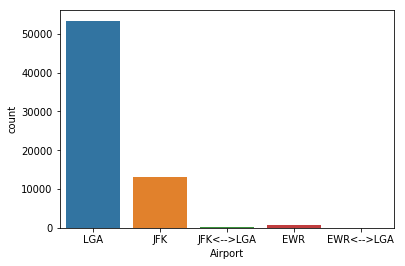

In [24]:
sns.countplot(x = "Airport", data = tripdata[tripdata["Airport"]!="Non-airport trip"])

Interesting that around 80% of the airport trips are from LGA! JFK comes distant second with 19% share. EWR trips are less than 1%.

In [25]:
tripdata.groupby("Airport")["Trip_distance", "Fare_amount", "Total_amount", "Tip_amount"].mean()

,Trip_distance,Fare_amount,Total_amount,Tip_amount
Airport,,,,
EWR,20.351000,75.761781,97.312370,11.412945
EWR<-->LGA,25.246667,82.000000,107.783333,9.136667
JFK,13.689311,41.356479,48.453845,5.148178
JFK<-->LGA,12.192626,27.945960,31.265960,2.653838
LGA,4.012609,14.812518,18.084289,1.633603
Non-airport trip,2.821203,12.160601,14.568166,1.179655


Some observations:

1. Are are a few trips which happen between two airports (for example, a trip between JFK and LGA). They are very small in number, so they wouln't affect the aggregation much.


2. EWR airport related trips have the highest average trip distance, fair amount, and tips. JFK comes second. LGA occupies distant third spot. 


3. Average fair amount for EWR trips is \\$75.76 where as it's \\$41.35 for JFK trips. For LGA is \\$14.81. Fare amount is correlated with the respective average trip distance.


4. One more interesting finding is that tip as percentage of total fare is also the order: EWR  > JFK  > LGA.  (11.72% > 10.62% > 9%).

In [26]:
# Creating a new dataframe with just airport related trips for analysis.
airport_trips = tripdata[tripdata["is_airport_trip"] == 1]

In [27]:
# Extracting distance column from both trips and non-airport trips.
dist_airport = airport_trips.Trip_distance
dist_non_airport = tripdata.loc[
    ~tripdata.index.isin(dist_airport.index), "Trip_distance"
]

# Removal  of datapoints which at 4 standard deviations away from median point.
dist_airport = dist_airport[
    ~((dist_airport - dist_airport.median()).abs() > 4 * dist_airport.std())
]
dist_non_airport = dist_non_airport[
    ~((dist_non_airport - dist_non_airport.median()).abs() > 4 * dist_non_airport.std())
]

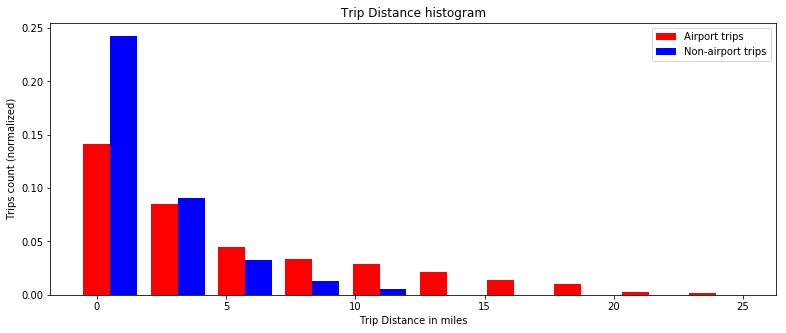

In [28]:
# Plotting histogram

bins = np.histogram(dist_airport, normed=True)[1]
airport_hist = np.histogram(dist_airport, bins=bins, normed=True)
non_airport_hist = np.histogram(dist_non_airport, bins=bins, normed=True)

# plot distributions of trip distance normalized among both airport trips and non-airport trips.
fig, axes = plt.subplots(1, 1, figsize=(13, 5))
w = 0.4 * (bins[1] - bins[0])
axes.bar(bins[:-1], airport_hist[0], alpha=1, width=w, color="r")
axes.bar(bins[:-1] + w, non_airport_hist[0], alpha=1, width=w, color="b")
axes.legend(["Airport trips", "Non-airport trips"])
axes.set_xlabel("Trip Distance in miles")
axes.set_ylabel("Trips count (normalized)")
axes.set_title("Trip Distance histogram")
plt.show()


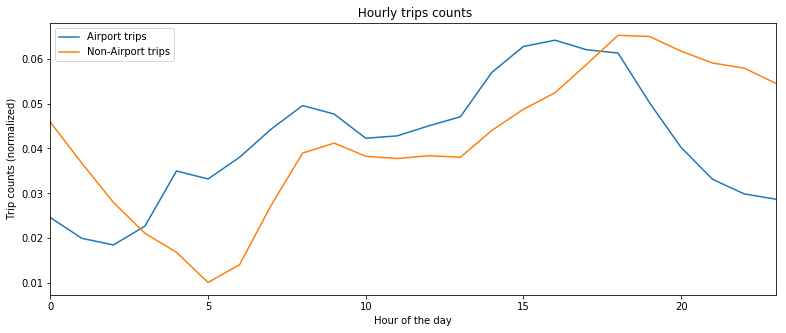

In [29]:
# Plotting trip count across time of the day for both aiport trips and non-airport trips separately.

fig, axes = plt.subplots(1, 1, figsize=(13, 5))
airport_trips.Pickup_Hour.value_counts(normalize=True).sort_index().plot(ax=axes)
tripdata.loc[~tripdata.index.isin(dist_airport.index), "Pickup_Hour"].value_counts(
    normalize=True
).sort_index().plot(ax=axes)
axes.set_xlabel("Hour of the day")
axes.set_ylabel("Trip counts (normalized)")
axes.set_title(" Hourly trips counts")
axes.legend(["Airport trips", "Non-Airport trips"])
plt.show()


#### Summary of analysis:

1. 4.50% of the trips are airport related trips (in number, around 67,309 trips). Among airport related trips, 80% are generated by LGA airport.


2. Average fare for airport trip is \\$20.65 where as it's \\$12.16 for non-airport trips. This is in agreement with the observation that average trip distance is significantly higher for airport trips (18 miles).This is most likely because of the fact that people visit the airports from distant inner city areas. 


3. Among airports, the average fare amount and tips are in the order: EWR > JFK > LGA. (More details are already provided during the analysis). The tip as a percent of total fair is also in the same order.


3. Based on the plot, I observed that the number of airport related trips are minimal at 2AM where as non-airport trips hit nadir at 5AM. From here, the number of trips increases steadily for both airport and non-airport trips till evening. The airports trips are maximum around 4PM where as non-airport trips peaks at 6PM. Aftter that, it starts decreasing.  


4. Airport trips follow the similar trend as the other trips for shorter distance trips.


Notes: 

(a) Vital assumption in my analysis is that any trip whose pickup or drop point is within the 1.5 miles radius from the airport is an airport-related trip.

(b) There are very few data points for EWR airports. So, we may not want to put forward very confident hypothesis about its aggregation.


## Question 4

> Part A:  Build a derived variable for tip as a percentage of the total fare.

Before we create the derived variable, let's check if there are any 0s in the Total_amount. Since we are dividing bt Total_amount, it's essential to take care of this.

In [30]:
tripdata[tripdata.Total_amount == 0].Total_amount.count()

4172

There are 4172 records with Total_amount being 0. Taxi website says that \\$2.5 is the initial charge. So, we need to remove the transactions in which total amount is less than $2.5.

In [31]:
# Removing transactions where total_amount is less than $2.5.
tripdata = tripdata[(tripdata["Total_amount"] >= 2.5)]

In [32]:
tripdata['Tip_Percent'] = 100*(tripdata.Tip_amount/tripdata.Total_amount)

In [33]:
print(tripdata.Tip_Percent.describe())

count    1.487767e+06
mean     6.665932e+00
std      8.875835e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e+01
max      1.000000e+02
Name: Tip_Percent, dtype: float64


In [34]:
tripdata[["Tip_amount","Total_amount","Tip_Percent"]].head()

,Tip_amount,Total_amount,Tip_Percent
0,1.95,9.75,20.00000
1,0.00,45.00,0.00000
2,0.50,5.80,8.62069
3,0.00,6.30,0.00000
4,0.00,6.30,0.00000


A derived variable for tip as a percentage of the total fare has been created. The above header illustrates that it's properly implemented.

>Part B: Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). Provide an estimate of performance using an appropriate sample, and show your work.

It's a regression problem since Tip_Percent is a continuous variable.

Target variable: Tip_Percent.

Predictor varialbes: Yet do decide. Needs data preparation and feature engineering.

###### Step 1: Data Preparation

Inclusing data cleaning, outliers removal, missing value handling.

In [35]:
tripdata.shape

(1487767, 33)

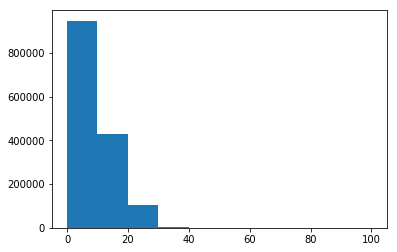

In [36]:
plt.hist(tripdata.Tip_Percent);

Evidently, we have so many trips with 0% tipping. Let's see what percent of the trips have 0% tipping.

In [37]:
print(f"{len(tripdata[tripdata.Tip_Percent == 0])/len(tripdata)} % trips have no tipping")

0.5948821287204247 % trips have no tipping


Almost 60% of the trips have 0% tip! This is expected because the definition of Tip_amount provided in the data dictionary this field captures only credit card tips. Cash tips are not included. I presume that the objective of the problem is to predicted recorded credit card tips.

In [38]:
tripdata.corr()["Tip_amount"].sort_values()

Payment_type            -0.527676
Trip_type               -0.010371
Dropoff_longitude       -0.010167
Extra                   -0.009743
Pickup_latitude         -0.009706
VendorID                -0.008553
Pickup_Hour              0.000044
MTA_tax                  0.001584
Distance_derived         0.003326
Dropoff_latitude         0.003821
Pickup_longitude         0.004340
Passenger_count          0.004592
RateCodeID               0.005856
improvement_surcharge    0.010628
is_airport_trip          0.106139
Tolls_amount             0.189300
Trip_distance            0.390522
Fare_amount              0.400603
Total_amount             0.576460
Tip_Percent              0.720367
Tip_amount               1.000000
Ehail_fee                     NaN
Name: Tip_amount, dtype: float64

Clearly,Tip_Percent is highly positively correlated with Tip_amount and Total_amount. Tip_Percent is highly negatively correlated with Payment_type. 

Though rest of predictors don't have very strong correlation, we can't just dismiss it. Because: (1) some of the predictors are categorical, so correlation coefficient doesn't make sense. (2) some features show correlation only after proper subset selection.

Let's see how many nulls we have in our data.

In [39]:
tripdata.isnull().sum()

VendorID                       0
lpep_pickup_datetime           0
Lpep_dropoff_datetime          0
Store_and_fwd_flag             0
RateCodeID                     0
Pickup_longitude               0
Pickup_latitude                0
Dropoff_longitude              0
Dropoff_latitude               0
Passenger_count                0
Trip_distance                  0
Fare_amount                    0
Extra                          0
MTA_tax                        0
Tip_amount                     0
Tolls_amount                   0
Ehail_fee                1487767
improvement_surcharge          0
Total_amount                   0
Payment_type                   0
Trip_type                      4
Pickup_Date                    0
Dropoff_Date                   0
Pickup_Hour                    0
Distance_derived               0
Dropoff_airport          1427374
Pickup_airport           1479463
is_airport_trip                0
JFK_related_trip         1474624
EWR_related_trip         1487036
LGA_relate

The Ehail_fee column contains only NaNs. It doesn't have any predictive power. So, let's just drop the column. 

In [40]:
# Deleting Ehail_fee if it exists. (if condition to avoid error in case of repeated compilation).
if "Ehail_fee" in tripdata.columns:
    tripdata.drop('Ehail_fee',inplace = True, axis = 1)

Trip_type has a few NaNs. Let's replace them with the 1 (which is the most common type of trip, Street-hailing).

In [41]:
# Replacing NaN with 1 in Trip_type.
tripdata['Trip_type '] = tripdata['Trip_type '].replace(np.NaN, 1)

In [42]:
tripdata["RateCodeID"].value_counts()

1     1451627
5       29802
2        4299
3        1091
4         912
6          32
99          4
Name: RateCodeID, dtype: int64

99 is not a valid code for RateCodeID as per the data dictionary. So, let's replace it with 1 (which represents Standard rate).

In [43]:
#Replacing invalid RateCodeID of 99 with 1.
tripdata.loc[tripdata[tripdata.RateCodeID == 99].index, "RateCodeID"] = 1

Data dictionary says that "Extra" only includes the \\$0.50 and \\$1 rush hour and overnight charges. So, let's replace all values other than 0.5 and 1 by 0 (which is the most common in dataset).

In [44]:
tripdata.Extra.value_counts()

 0.00     678629
 0.50     566408
 1.00     242727
 12.00         1
-0.72          1
 0.25          1
Name: Extra, dtype: int64

In [45]:
# Replacing invalid values by 0.
tripdata.loc[
    tripdata[
        ~((tripdata.Extra == 0) | (tripdata.Extra == 0.5) | (tripdata.Extra == 1))
    ].index,
    "Extra",
] = 0

Investigation of the value ranges showed that the following features have negative values so many observations: features Total_amount, Fare_amount, Tip_amount, Tolls_amount, MTA_tax, Extra, improvement_surcharge. This is most likely due to human entry error. Let's convert the negative numbers into absolute values.

In [46]:
# Converting negative values into absolute values.
features_with_negative_values = [
    "Total_amount",
    "Fare_amount",
    "Tip_amount",
    "Tolls_amount",
    "MTA_tax",
    "Extra",
    "improvement_surcharge",
    "Tip_Percent"
]

for f in features_with_negative_values:
    tripdata[f] = tripdata[f].abs()

###### Step 2: Feature Engineering and EDA

Creating a Trip_duration feautre which is the time difference between dropoff and pickup for each trip.

In [47]:
# Getting duration of the trip by computng the difference between Dropoff time and Pickup time.
tripdata["Trip_Duration"] = (tripdata["Dropoff_Date"] - tripdata["Pickup_Date"]).apply(
    lambda d: d.total_seconds() / 60.0
)


Before we divide distance by time to get the speed, let's see if there are any records with duration of trip being 0.

In [48]:
tripdata[tripdata["Trip_Duration"]==0]["Trip_Duration"].count()

995

Let's remove these 995 records with 0 duration.

In [49]:
tripdata = tripdata[(tripdata["Trip_Duration"] != 0)]

In [50]:
# Creating a varialbe for average trip speed.
tripdata['Trip_Speed'] = tripdata["Trip_distance"]/(tripdata["Trip_Duration"]/60)

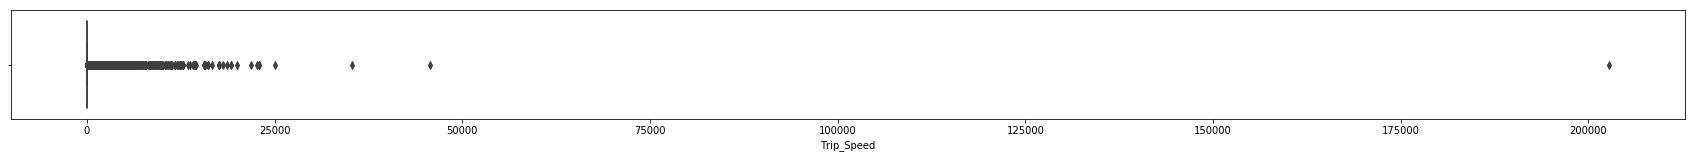

In [51]:
plt.figure(figsize=[30,2])
sns.boxplot(tripdata['Trip_Speed'])

It's inconceivable that the trip speed for around 2500 records is more than 150 MPH. Given the traffic congestion in NYC and also the imposed speed limit on Taxis, these figures could very well be errors. The closer inspection of the data revealed that these are the trips with minimal trip duration. That is to say that we don't have much confidence these records.

Two options to get rid of this aberration.

(1) Replace the trip speed for these obervations by median or by random sampling.

(2) Delete these observations.

Since we have more than a million records, we can sacrifice these 2.5k records. Let's go with option (2) and remove them.

In [52]:
tripdata[tripdata['Trip_Speed'] > 150].Trip_Speed.count()

2429

In [53]:
#Retaining only those records for which speed is less than 150mph.
tripdata = tripdata[tripdata['Trip_Speed'] < 150]

The day, week, and hour presumably impacts the tipping. So, let's create features for them using Pickup_date.

In [54]:
sept_2015_week_1 = datetime(2015,9,1).isocalendar()[1] 

#Pickup_Hour was already created for Q 3(a). Let's create other time related variables.
tripdata['Pickup_Week'] = tripdata["Pickup_Date"].apply(lambda w:w.isocalendar()[1]) - sept_2015_week_1 + 1 #1 to 5
tripdata['Pickup_Monthly_day'] = tripdata["Pickup_Date"].apply(lambda m:m.day) #1 to 30. (September has 30 days).
tripdata['Pickup_Weekly_Day']  = tripdata["Pickup_Date"].apply(lambda w:w.isocalendar()[2]) #1 to 7

In [55]:
tripdata.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'improvement_surcharge', 'Total_amount',
       'Payment_type', 'Trip_type ', 'Pickup_Date', 'Dropoff_Date',
       'Pickup_Hour', 'Distance_derived', 'Dropoff_airport', 'Pickup_airport',
       'is_airport_trip', 'JFK_related_trip', 'EWR_related_trip',
       'LGA_related_trip', 'Airport', 'Tip_Percent', 'Trip_Duration',
       'Trip_Speed', 'Pickup_Week', 'Pickup_Monthly_day', 'Pickup_Weekly_Day'],
      dtype='object')

We have sevaral categorical predictor variables. Since they are not ordinal, ML algorithms can't make sense of these variables. Let's convert these varialbes into dummy/indicator varialbes using one-hot encoding. (The categorical variables that we have are mostly low cardinality variables, so we won't have the "curse of dimensionality" problem).

While doing so, let's make sure to avoid multicolinearity by setting drop_first = True. This makes sure that only k-1 dummies out of k categorical levels are created by removing the first level. Doing this is essential because kth dummy varialve can be expressed as the linear combination of (k-1) dummy varialbes. In other words, kth variable doens't add any new precitive power.

In [56]:
# Renaming to remove the unwanted space at the end of column name.
tripdata = tripdata.rename(columns={'Trip_type ': 'Trip_type'})

# Conveting Trip_type from float to int.
tripdata["Trip_type"] = tripdata["Trip_type"].astype(int)

In [57]:
# Listing the features which are categorical and needs one-hot encoding.
categorical_features = ["VendorID","Store_and_fwd_flag","RateCodeID","Payment_type", "Trip_type"]

for item in categorical_features:
    print(item, " has unique values: ", tripdata[item].unique())

VendorID  has unique values:  [2 1]
Store_and_fwd_flag  has unique values:  ['N' 'Y']
RateCodeID  has unique values:  [5 1 2 4 3 6]
Payment_type  has unique values:  [1 2 3 4 5]
Trip_type  has unique values:  [2 1]


In [58]:
# Creating categorical objects.

VendorID_categories = [1,2]
Store_and_fwd_flag_categories = ["Y","N"]
RateCodeID_categories = [1,2,3,4,5,6]
Payment_type_categories = [1,2,3,4,5,6]
Trip_type_categories = [1,2]


for feature in categorical_features:
    tripdata[feature] = pd.Series(tripdata[feature])
    tripdata[feature] = tripdata[feature].astype('category', categories = globals()[feature +'_' + 'categories'])
    
tripdata = pd.get_dummies(tripdata, columns = categorical_features, drop_first = True)

In [59]:
len(list(tripdata))

45

Clearly, we have highly correlated predictor variables. For example, we have two features Total_amount and Fare_amount which have a correlation coefficient of 0.97! 

This is problematic as correlated predictors cause **multicolinearity**. In simple terms, model becomes unstable when features are correlated with each other. We are concerned about the "independent variation" of predictor variable and its influence on tip percentage. When two predictors (like Total_amount and Fare_amount) are highly correlated,  we don't have independent variation. One of the predictors becomes redundant.

Let's check if Total_amount can be deduced perfectly from the rest of amounts.

In [60]:
tripdata["Deduced_Total_amount"] = tripdata[
    [
        "Fare_amount",
        "Extra",
        "MTA_tax",
        "Tip_amount",
        "Tolls_amount",
        "improvement_surcharge",
    ]
].sum(axis=1)

In [61]:
tripdata['Deduced_Total_amount'].corr(tripdata['Total_amount'])

0.9999969629850343

Oh! Clearly, the Total_amount column gives away the Tip_amount if we use it in our model. This is a classic example of "**Data leakage**". The model built using all the columns including Total_amount would perform exceptionally well in predicting the tip amount, but such a model is worthless becasue Total_amount data would not be available during infernece time. 

In other words, the model can deduce the tip amount as a linear combination of the rest of columns.

So, let's delete Total_amount column.

In [63]:
tripdata.drop(["Total_amount", "Deduced_Total_amount"], inplace=True, axis=1, errors="ignore")

In [64]:
tripdata.head()

,lpep_pickup_datetime,Lpep_dropoff_datetime,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,...,RateCodeID_3,RateCodeID_4,RateCodeID_5,RateCodeID_6,Payment_type_2,Payment_type_3,Payment_type_4,Payment_type_5,Payment_type_6,Trip_type_2
0,2015-09-01 00:02:34,2015-09-01 00:02:38,-73.979485,40.684956,-73.979431,40.685020,1,0.00,7.8,0.0,...,0,0,1,0,0,0,0,0,0,1
1,2015-09-01 00:04:20,2015-09-01 00:04:24,-74.010796,40.912216,-74.010780,40.912212,1,0.00,45.0,0.0,...,0,0,1,0,0,0,0,0,0,1
2,2015-09-01 00:01:50,2015-09-01 00:04:24,-73.921410,40.766708,-73.914413,40.764687,1,0.59,4.0,0.5,...,0,0,0,0,0,0,0,0,0,0
3,2015-09-01 00:02:36,2015-09-01 00:06:42,-73.921387,40.766678,-73.931427,40.771584,1,0.74,5.0,0.5,...,0,0,0,0,1,0,0,0,0,0
4,2015-09-01 00:00:14,2015-09-01 00:04:20,-73.955482,40.714046,-73.944412,40.714729,1,0.61,5.0,0.5,...,0,0,0,0,1,0,0,0,0,0


In [65]:
tripdata.columns

Index(['lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'improvement_surcharge', 'Pickup_Date',
       'Dropoff_Date', 'Pickup_Hour', 'Distance_derived', 'Dropoff_airport',
       'Pickup_airport', 'is_airport_trip', 'JFK_related_trip',
       'EWR_related_trip', 'LGA_related_trip', 'Airport', 'Tip_Percent',
       'Trip_Duration', 'Trip_Speed', 'Pickup_Week', 'Pickup_Monthly_day',
       'Pickup_Weekly_Day', 'VendorID_2', 'Store_and_fwd_flag_N',
       'RateCodeID_2', 'RateCodeID_3', 'RateCodeID_4', 'RateCodeID_5',
       'RateCodeID_6', 'Payment_type_2', 'Payment_type_3', 'Payment_type_4',
       'Payment_type_5', 'Payment_type_6', 'Trip_type_2'],
      dtype='object')

In [66]:
tripdata.LGA_related_trip.unique()

array([nan, 'LGA'], dtype=object)

In [67]:
tripdata['JFK_related_trip'] = tripdata['JFK_related_trip'].replace(np.NaN, 0)
tripdata['JFK_related_trip'] = tripdata['JFK_related_trip'].replace("JFK", 1)

tripdata['EWR_related_trip'] = tripdata['EWR_related_trip'].replace(np.NaN, 0)
tripdata['EWR_related_trip'] = tripdata['EWR_related_trip'].replace("EWR", 1)

tripdata['LGA_related_trip'] = tripdata['LGA_related_trip'].replace(np.NaN, 0)
tripdata['LGA_related_trip'] = tripdata['LGA_related_trip'].replace("LGA", 1)

In [68]:
tripdata.Airport.unique()

array(['Non-airport trip', 'LGA', 'JFK', 'JFK<-->LGA', 'EWR',
       'EWR<-->LGA'], dtype=object)

To get rid of redundant predictors, let's use **Variance Inflation Factor (VIF)**. This is a measure which tells the severity of multicolinearity. Higher the VIF, higher the severity of multicolinearity. Let's create a new dataframe with plausible predictor list to feed as input for VIF checking function.

In [77]:
#Making a list of predictors which could be used in modelling.

predictor_list = ["Passenger_count", "Trip_distance", "Fare_amount", "Extra", "MTA_tax", "Tolls_amount",
                 "improvement_surcharge", "Pickup_Hour", "JFK_related_trip", "EWR_related_trip", 
                 "LGA_related_trip", "Trip_Duration", "Trip_Speed", "Pickup_Week", "Pickup_Monthly_day", 
                  "Pickup_Weekly_Day", "VendorID_2", "Store_and_fwd_flag_N", "RateCodeID_2", "RateCodeID_3",
                 "RateCodeID_4", "RateCodeID_5", "RateCodeID_6", "Payment_type_2", "Payment_type_3", "Payment_type_4",
                 "Payment_type_5", "Payment_type_6", "Trip_type_2"]

df = tripdata[predictor_list]

In [80]:
df.head()

,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tolls_amount,improvement_surcharge,Pickup_Hour,JFK_related_trip,EWR_related_trip,...,RateCodeID_3,RateCodeID_4,RateCodeID_5,RateCodeID_6,Payment_type_2,Payment_type_3,Payment_type_4,Payment_type_5,Payment_type_6,Trip_type_2
0,1,0.00,7.8,0.0,0.0,0.0,0.0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,0.00,45.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,1,0.59,4.0,0.5,0.5,0.0,0.3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.74,5.0,0.5,0.5,0.0,0.3,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0.61,5.0,0.5,0.5,0.0,0.3,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [82]:
# The following function is adapted from here:
# https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-in-python

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc) + '. It has a VIF of: ' + str(max(vif)))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [83]:
df = calculate_vif_(df)

dropping 'Pickup_Week' at index: 13. It has a VIF of: 41123.657589316055
dropping 'MTA_tax' at index: 4. It has a VIF of: 1239.374792955686
dropping 'improvement_surcharge' at index: 5. It has a VIF of: 177.5774194667914
dropping 'Store_and_fwd_flag_N' at index: 14. It has a VIF of: 25.725197321486203
dropping 'RateCodeID_5' at index: 17. It has a VIF of: 21.26373997248065
dropping 'Fare_amount' at index: 2. It has a VIF of: 12.235188946716937
dropping 'Trip_Speed' at index: 9. It has a VIF of: 6.663554008395739
Remaining variables:
Index(['Passenger_count', 'Trip_distance', 'Extra', 'Tolls_amount',
       'Pickup_Hour', 'JFK_related_trip', 'EWR_related_trip',
       'LGA_related_trip', 'Trip_Duration', 'Pickup_Monthly_day',
       'Pickup_Weekly_Day', 'VendorID_2', 'RateCodeID_2', 'RateCodeID_3',
       'RateCodeID_4', 'RateCodeID_6', 'Payment_type_2', 'Payment_type_3',
       'Payment_type_4', 'Payment_type_5', 'Payment_type_6', 'Trip_type_2'],
      dtype='object')


In [88]:
print("The number of features now is", df.shape[1])

The number of features now is 22


###### Modelling

In [101]:
df.head()

,Passenger_count,Trip_distance,Extra,Tolls_amount,Pickup_Hour,JFK_related_trip,EWR_related_trip,LGA_related_trip,Trip_Duration,Pickup_Monthly_day,...,RateCodeID_2,RateCodeID_3,RateCodeID_4,RateCodeID_6,Payment_type_2,Payment_type_3,Payment_type_4,Payment_type_5,Payment_type_6,Trip_type_2
0,1,0.00,0.0,0.0,0,0,0,0,0.066667,1,...,0,0,0,0,0,0,0,0,0,1
1,1,0.00,0.0,0.0,0,0,0,0,0.066667,1,...,0,0,0,0,0,0,0,0,0,1
2,1,0.59,0.5,0.0,0,0,0,0,2.566667,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0.74,0.5,0.0,0,0,0,0,4.100000,1,...,0,0,0,0,1,0,0,0,0,0
4,1,0.61,0.5,0.0,0,0,0,0,4.100000,1,...,0,0,0,0,1,0,0,0,0,0


Let's build a regression model to predict tip percentage.

In [133]:
X = df
y = tripdata["Tip_Percent"]

# Splitting the data into train and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=99)

Let's start with multiple linear regression (MLR).

In [134]:
mlr_model = lm.LinearRegression()
mlr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [135]:
y_pred_train = mlr_model.predict(X_train)
y_pred = mlr_model.predict(X_test)

In [136]:
# Printing performannce metrics of the model.
print(f" RMSE = {np.sqrt(mt.mean_squared_error(y_train, y_pred_train))}")
print(f" R-squared = {mt.r2_score(y_train, y_pred_train)}")

 RMSE = 5.295457055657113
 R-squared = 0.6401819519261995


In [137]:
# Printing performannce metrics of the model.
print(f" RMSE = {np.sqrt(mt.mean_squared_error(y_test, y_pred))}")
print(f" R-squared = {mt.r2_score(y_test, y_pred)}")

 RMSE = 5.314865851328019
 R-squared = 0.6402294141922933


In [111]:
# Saving the regression model to disk.
filename = 'mlr_model.pkl'
pickle.dump(mlr_model, open(filename, 'wb'))

Let's try Random Forest Regressor.

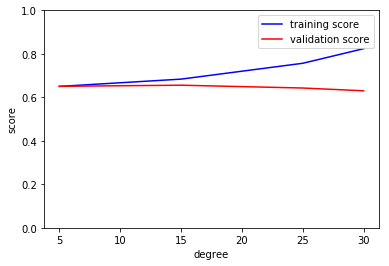

In [151]:
# Drawing validation curve for max_depth.
max_depth_values = np.array([5,15,25,30])
train_score, val_score = validation_curve(RandomForestRegressor(n_estimators=100), X_train, y_train, 'max_depth', max_depth_values, cv=4)

plt.plot(max_depth_values, np.median(train_score, 1), color='blue', label='training score')
plt.plot(max_depth_values, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('max_depth_value')
plt.ylabel('R squared score');

If we have only one hyperparamer, then we can select the most optimal value by plotting the validation curve as shown above. However, we have multiple hyperparamers. So, it makes less sense to do this for each hyperparamter. (We have to see how model performs for different "combinations" of hyperparameters). So, let's use grid search.

In [162]:
# Specifying different values for hyperparameters.
param_grid = {"max_depth": [5, 10, 15, 20],
              "max_features": ["auto", "sqrt", "log2"],
              "min_samples_split": [2, 5, 10]}

regr = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score = True) 

# Grid search for finding the optimal hyperparamers.
gs_model = GridSearchCV(estimator=regr, param_grid=param_grid, cv= 4)

In [163]:
gs_model

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 10, 15, 20], 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [164]:
gs_model.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 10, 15, 20], 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [166]:
gs_model.best_params_

{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5}

In [167]:
y_pred_train = gs_model.predict(X_train)
y_pred = gs_model.predict(X_test)

In [169]:
# Printing performannce metrics of the model on train data.
print(f" RMSE = {np.sqrt(mt.mean_squared_error(y_train, y_pred_train))}")
print(f" R-squared = {mt.r2_score(y_train, y_pred_train)}")

 RMSE = 4.883445681790098
 R-squared = 0.6939948290341966


In [170]:
# Printing performannce metrics of the model on test data.
print(f" RMSE = {np.sqrt(mt.mean_squared_error(y_test, y_pred))}")
print(f" R-squared = {mt.r2_score(y_test, y_pred)}")

 RMSE = 5.179235227284
 R-squared = 0.6583571699738957


Let's plot the residual plot to see if there's any pattern in it (if there is, it means that the model hasn't fully extracted all info from the features).

In [171]:
residual = y_test - y_pred

(-40, 40)

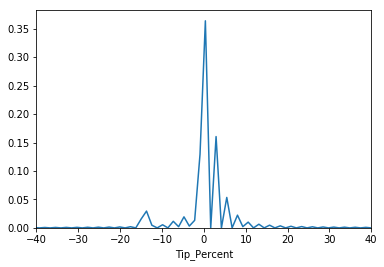

In [182]:
# Plotting the distribution of the residuals.
sns.distplot(residual, hist=False)
plt.xlim(-40, 40)

From the above plot, the residual is clearly centered around 0 (not perfectly though).

**A few comments**:

(1) There's still a lot of scope to improve the above model. We could tune all the hyperparameters with wide range of values.

(2) We can try time series model (given that we can time order in dataset, we exploit the temporal variations to come up with a much more sophisticated model.

(3) We could try boosting methods using packages like XGBoost, LightGBM, CatBoost, etc.

(4) In the models built above, to avoid multiconinearity I have used the subset of features which have the VIF less than 5. That's not really required for ensemble methods like Random Forest though. They work reasonably well even if the features are somewhat correlated. That being said, the elimination of correlated features becomes crucial when we would using the coefficients of the regression model to explain the causal relationships between the predictors and the target variable.


## Question 5

>Part 1: Build a derived variable representing the average speed over the course of a trip.

I have already derived a variable for average speed during feature engineering for part 4(b). The name of the feature is: Trip_Speed. It's unit is Miles per Hour (MPH).


Trip_Speed = Trip_distance/Trip_duration.

where: Trip_duration = Dropoff_time - Pickup_time.

I have taken take anomalies in the trip speed.

In [188]:
tripdata["Trip_Speed"].describe()

count    1.484340e+06
mean     1.287465e+01
std      6.249432e+00
min      0.000000e+00
25%      9.323077e+00
50%      1.176755e+01
75%      1.504478e+01
max      1.494340e+02
Name: Trip_Speed, dtype: float64

>Part 2: Can you perform a test to determine if the average trip speeds are materially the same in all weeks of September? If you decide they are not the same, can you form a hypothesis regarding why they differ?

Before I perform the statistical test, let me aggregate the trip speed by week using groupby method.

In [189]:
tripdata[['Trip_Speed','Pickup_Week']].groupby('Pickup_Week').mean()

,Trip_Speed
Pickup_Week,
1,13.316916
2,12.650552
3,12.647512
4,13.126582
5,12.463287


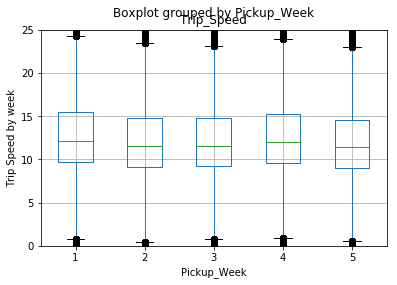

In [190]:
#Boxplot of Trip Speed by week.
tripdata.boxplot('Trip_Speed','Pickup_Week')
plt.ylim([0,25]) 
plt.ylabel('Trip Speed by week')
plt.show()

From the aggregation table, ostensibly the means vary across weeks (but not too much). We are not sure if it's statistically significant enough to conclude that speed varies based on weeks. Therefore, let's perform hypothesis testing.

I'm going to use pairwise T test to statistically examine if the average trip speeds are materially the same in all weeks of September. Pairwise T test takes means of two populations as input and gives p-value. 

>Null Hypothesis: Two samples have same mean. $β_{1}$ = $β_{2}$

>Alternative Hypothesis: Two samples have different mean. $β_{1}$ ≠ $β_{2}$

We reject the null hypothesis only if the p-value is significant. In other words, we reject the null hypothesis if the estimates $β_{1}$ and $β_{2}$ are sufficiently dissimilar. 

How do we say if they are sufficiently dissimilar? P-value. 

P-value, in this context, is the probability of getting estimates $β_{1}$ and $β_{2}$ as dissimilar as we have got, under the assumption that null hypothesis is true. That is to say that if p-value is very small, then it's very unlikely that the dissimilarity happened by chance; the true means of the distribution could indeed be different.

Now, we have to perform mean eqality test for 5 different weeks of September. In order to do that, we need to compare every week with every oterh week. So, in total, we need to perform 5x5 = 25 T tests.




In [191]:
pd.unique(tripdata.Pickup_Week)

array([1, 2, 3, 4, 5])

In [192]:
# Perfomring 25 T tests. Each week with every other week.
Sept_Weeks = pd.unique(tripdata.Pickup_Week)


p_value_by_hour = []

for m in range(1, 6):
    for n in range(1, 6):
        p_value_by_hour.append(
            (
                m,
                n,
                st.ttest_ind(
                    tripdata[tripdata["Pickup_Week"] == m]["Trip_Speed"],
                    tripdata[tripdata["Pickup_Week"] == n]["Trip_Speed"],
                )[1],
            )
        )

p_values_table = pd.DataFrame(p_value_by_hour, columns=["Week_v", "Week_h", "p_value"])
print("Table of p-values:")
p_values_table.pivot_table(index="Week_v", columns="Week_h", values="p_value")

Table of p-values:


Week_h,1,2,3,4,5
Week_v,,,,,
1,1.000000e+00,0.000000e+00,0.000000e+00,7.301061e-33,0.000000e+00
2,0.000000e+00,1.000000e+00,8.346850e-01,6.275849e-219,1.124357e-20
3,0.000000e+00,8.346850e-01,1.000000e+00,1.918078e-226,9.717218e-21
4,7.301061e-33,6.275849e-219,1.918078e-226,1.000000e+00,1.251027e-230
5,0.000000e+00,1.124357e-20,9.717218e-21,1.251027e-230,1.000000e+00


**Interpretation:** 

Interpretation of p value: It's the probability of getting t-statistic as extreme as the one we obtained under the assumption that null hypothesis is true (which is that average speed is same across all the weeks of Stemeber). 

Since p-values of most of the 25 statitical tests are less than the significance level (0.05), it's unlikely that we got the the results out of chance. We can say that the dissimilarity of the means are statistically significant. Therefore, we reject null hypothesis. We accept the alternative hypothesis that average speed is not same across different weeks of the month.

Alternatively, we can also perform one-way ANOVA tests to check the null hypothesis that two or more groups have the same population mean. Let me do that as well.

In [193]:
weekwise_data = []

# Extracting trip speed for each week.
for w in pd.unique(tripdata.Pickup_Week):
    weekwise_data.append(tripdata[tripdata['Pickup_Week'] == w].Trip_Speed.as_matrix())    

In [194]:
#Performing one-way ANOVA test.
st.f_oneway(*weekwise_data)

F_onewayResult(statistic=887.4110863718852, pvalue=0.0)

**Interpretation:** Since the F value is very high and p-value is almost 0, we reject the null hypothesis that average trip speeds are materially the same in all weeks of September. The difference between average speed in different weeks is statistically significcant. Therefore, we accept the alternative hypothesis that average trip speeds are not same in all weeks of September.

###### Hypothesis regarding why average trip speed differ across weeks:

Evidently, average trip speed varies across different weeks of the month. In fact, they are in the order: 1st week > 4th week > 2nd week > 3rd week > 5 week.

We could hypothesize that traffic congestion varies based on time of the month which in turn affects the average trip speed. The level of traffic congestion is one of the main determinants of average speed.  As we can observe in our aggregated data, the average speed is highest in the first weke of the month and lowest in fifth week. It could be that people travel more at the outset of the month. 

These variations could also be driven by specific events which happened in the city in Sept 2015. Music concerts, sports events can influence the traffic congestion and average trip speed. US Open Tennis tournament, for example, has happened in New York City during September, 2015. Events like these would have non-trivial effect the trip speed variation. By analysing the average speed during other months (August, October, November, etc of 2015), we may be able to make confident assertions about the variation of average speed across time. 

>Part 3: Can you build up a hypothesis of average trip speed as a function of time of day?

In [195]:
tripdata[['Trip_Speed','Pickup_Hour']].groupby('Pickup_Hour').mean()

,Trip_Speed
Pickup_Hour,
0,14.593725
1,14.849105
2,15.027386
3,15.403642
4,16.247233
5,17.979547
6,16.985343
7,13.491539
8,12.290240


Hypothesis:

We have perform a statistical test to check if the average trip speeds are materially the same in all hours of the day. 

>Null Hypothesis: The trip speed is same in all hours of the day.

>Alternative Hypothesis: The trip speed are not same in all hours of the day.

We reject the null hypothesis only if the p-value is significant. In other words, we reject the null hypothesis if the means of the trip speeds are sufficiently dissimilar. 



Before performing the statisitcal test, let's plot the trip speed by hour of the day and see if anything is visually apparent.

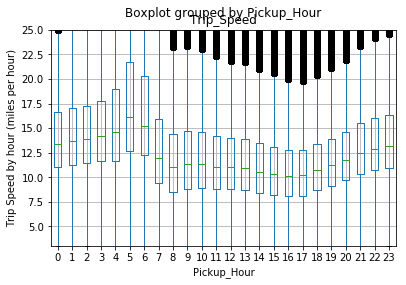

In [196]:
#Boxplot of Trip Speed by hour.
tripdata.boxplot('Trip_Speed','Pickup_Hour')
plt.ylim([3,25]) 
plt.ylabel('Trip Speed by hour (miles per hour)')
plt.show()

It's evident from the above boxplots that the average trip speed reaches its pinnacle at 5AM and then slowly decreases and reaches the lowest point at 5PM. After 5PM, it slowly increases till the midnight. The reason for higher speed in the early morning (from 3AM to 6AM) could be that there'd be minimal traffic congestion during that time. 

Looking at the above aggregation, it seems like the speed varies based on hour of the day. Let me perform ANOVA test to check if it's statistically significant. 

In [197]:
hourly_list = list()

for i in range(0, 24):
    hourly_list.append(tripdata[tripdata["Pickup_Hour"] == i].Trip_Speed.as_matrix())

anova_test = st.f_oneway(*hourly_list)

print("The result of ANOVA test:", anova_test)

The result of ANOVA test: F_onewayResult(statistic=4243.462409703313, pvalue=0.0)


**Interpretation:** 

Interpretation of p-value: This is the probability of getting an F-statistic value as extreme as 4243.46 under the assumption that null hypothesis is true (which is that average speed is same throughout the day). Since p-value is essentially 0, we can say that we did not get this  extreme F-statistic out of chance. The difference in average speed across different hours in a day is statistically significant. We reject the null hypothesis tha tthey are same. We accept the alternative hypothesis that average speed is not same throughout the day.

--------------